In [1]:
## import the tools
import torch
import glob
from pathlib import Path
import os
import numpy as np
from sklearn.neighbors import NearestNeighbors as NN
import glob
import pandas as pd
import ipdb

In [2]:
## import the model tools
from torch_geometric.transforms import Compose
from torch_points3d.core.data_transform import MinPoints,XYZFeature, AddFeatsByKeys, GridSampling3D
from torch_points3d.applications.pretrained_api import PretainedRegistry
from torch_geometric.data import Batch,Dataset, Data ,DataLoader


In [3]:
## transformer
pos_z = [ "pos_z" ]
list_add_to_x = [ True ]
delete_feats = [ True ]
lparams = ['512']

first_subsampling = 0.02
transform_test = Compose([MinPoints(512),
                     XYZFeature(add_x=False, add_y=False, add_z= True),
                     AddFeatsByKeys(list_add_to_x=list_add_to_x, feat_names= pos_z,delete_feats=delete_feats),
                     GridSampling3D(mode='last', size=first_subsampling, quantize_coords=True)])

In [4]:
## to find the neighbor points prediction
from sklearn.neighbors import BallTree, KDTree
import numpy as np
def get_nearest(src_points, candidates, k_neighbors=1):
    """Find nearest neighbors for all source points from a set of candidate points"""
    # src : whole gt points in a file 
    tree = KDTree(candidates, leaf_size=20, metric='euclidean')

    # Find closest points and distances
    distances, indices = tree.query(src_points, k=k_neighbors)

    # Transpose to get distances and indices into arrays
    distances = distances.transpose()
    indices = indices.transpose()

    # Get closest indices and distances (i.e. array at index 0)
    closest = np.squeeze(indices)
    closest_dist = distances

    return closest

In [5]:
model_folder = "2023-03-29/13-31-16/"
root_path = "/home/jf/Documents/msc/torch-3dpoints-powerline/"
pl_models_path = root_path+ "outputs/" + model_folder + "SEUNet18.pt" 
model = torch.load(pl_models_path)
model['run_config']['data']['dataroot'] = '/home/jf/msc_data'
torch.save(model, root_path+ "outputs/" + model_folder + "SEUNet18.pt")

In [6]:
## powline model
model_folder = "2023-03-29/13-31-16/"
root_path = "/home/jf/Documents/msc/torch-3dpoints-powerline/"
pl_models_path = root_path+ "outputs/" + model_folder + "SEUNet18" 

model_pl = PretainedRegistry.from_file(pl_models_path).cuda()

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
loading processed train split
Total of 529 samples in train set.
loading processed val split
Total of 58 samples in val set.
loading processed test split
Total of 76 samples in test set.


INFO - 2023-03-30 20:15:31,607 - model_checkpoint - Available weights : ['latest', 'loss_seg', 'acc', 'macc', 'miou']
INFO - 2023-03-30 20:15:31,608 - model_checkpoint - Model loaded from SEUNet18.pt:latest
INFO - 2023-03-30 20:15:31,693 - bn_schedulers - Setting batchnorm momentum at 0.1


## Process with the normalize data

In [7]:
## load test pt with normalized

## load transform pt pre
# root_path = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/denmark/processed/"
# root_path = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed/"
#data_root_path = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/exp_2205/denmark/processed_new/"
data_root_path = "/home/jf/msc_data/denmark/processed_hough"
test_fold = data_root_path + "/test_0_(0.1, 0.1)/"
# pre_trans_path = root_path + "test_0_(0.05, 0.05)/stats.pt"
# test_fold = root_path + "test_0_(0.1, 0.1)/"
pre_trans_path = test_fold + "/stats.pt"
process_file_name_path = test_fold + "/processed_file_names.pt"
vis_out_folder = data_root_path + '/vis/'

pre_transform = torch.load(pre_trans_path)
process_file_name = torch.load(process_file_name_path)

In [8]:
pre_transform

{'room_names': ['PUNKTSKY_00005_1km_6211_474'],
 'room_coord_min': [array([ 4.7416593e+05,  6.2110000e+06, -3.1600000e+00])],
 'room_coord_max': [array([4.74999990e+05, 6.21199999e+06, 1.41460000e+02])],
 'room_coord_scale': [array([ 83.406,  99.999, 144.62 ])],
 'global_z': (-3.16, 141.46)}

In [9]:
## loop for every files
## delete files
count = 0
global_z = pre_transform['global_z']
# for i in range(count_list):
room_names = pre_transform['room_names']
room_coord_mins = pre_transform['room_coord_min']
room_coord_maxs = pre_transform['room_coord_max']
room_coord_scales = pre_transform['room_coord_scale']
count = 0
for file in glob.glob(test_fold + "*cloud*pt"):
#     print(file)
    sample = os.path.join(test_fold, file)
    pt_data = torch.load(sample)
    room_index = pt_data['room_idx']
    room_name = room_names[room_index]
    vis_out = os.path.join(vis_out_folder, room_name)
    #Path(vis_out_folder).mkdir(exist_ok=True, parents=True)
    #print(vis_out)
#     ipdb.set_trace()

    room_coord_scale = room_coord_scales[room_index]
    pos_ = pt_data['points']
    pt_ori = pt_data['points'] * room_coord_scale + pt_data['coord_min']
    data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
    # data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
    data_s.y = torch.zeros(data_s.batch.shape).long()
    f = get_nearest(pos_, data_s.pos)

    with torch.no_grad():
        model_pl.eval()
        model_pl.set_input(data_s, "cuda")
        model_pl.forward(data_s)
    
    pre = model_pl.output.cpu().numpy()
    m= torch.nn.functional.softmax(torch.tensor(pre), dim=1)
    cla_pre = np.argmax(m, axis=1)
    pre_ori = np.arange(len(pos_))
    for i in pre_ori:
#         print(i)
        pre_ori[i] = cla_pre[f[i]]
    combine_pre = np.column_stack((pt_ori, pre_ori.T))
#     import ipdb;ipdb.set_trace()
    vis_out = vis_out_folder + room_name +'pre.txt'
    if os.path.exists(vis_out):
        file_save = open(vis_out, 'a')
    else:
        file_save = open(vis_out, 'w')

    file_save = open(vis_out_folder + room_name +'pre.txt', 'a')
    np.savetxt(file_save, combine_pre, fmt = '%1.5f')
#     file_save.write("\n")    
#     break
print("save finished")

save finished


### Simple vis

In [10]:
## read path
vis_out_folder
pred_path = os.path.join(vis_out_folder, "PUNKTSKY_00005_1km_6211_474pre.txt")
pred_data = pd.read_csv(pred_path, sep=" ", header=None).values
pred_data, pred_data.shape

(array([[4.74206670e+05, 6.21130000e+06, 4.43100000e+01, 0.00000000e+00],
        [4.74206940e+05, 6.21130003e+06, 4.43300000e+01, 0.00000000e+00],
        [4.74207220e+05, 6.21130006e+06, 4.43000000e+01, 0.00000000e+00],
        ...,
        [4.74902360e+05, 6.21169982e+06, 5.64000000e+01, 0.00000000e+00],
        [4.74902650e+05, 6.21169979e+06, 5.63900000e+01, 0.00000000e+00],
        [4.74902920e+05, 6.21169977e+06, 5.63900000e+01, 0.00000000e+00]]),
 (25375265, 4))

In [16]:
np.sum(pred_data[:,-1])

13840436.0

In [11]:
## vis
import matplotlib.pyplot as plt
import matplotlib
#%matplotlib notebook

In [12]:
idx = np.arange(len(pred_data))
np.random.shuffle(idx)
idx = idx[:30000]

vmin = pred_data[idx, -1].min()
vmax = pred_data[idx, -1].max()
cm = plt.colormaps['RdYlBu']

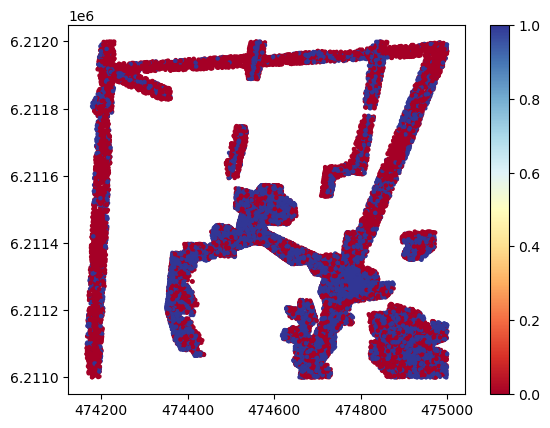

In [13]:
plt.figure()
sc = plt.scatter(pred_data[idx, 0], pred_data[idx, 1], c =pred_data[idx, -1],
                cmap=cm, vmin=vmin, vmax=vmax, s=5
            )
plt.colorbar(sc)

### check the individual pt


In [14]:
onesample = test_fold + "PUNKTSKY_00005_1km_6090_507_cloud_194.pt"
onesample = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed/test_0_(0.05, 0.05)/PUNKTSKY_00005_1km_6090_507_cloud_335.pt"
pt_data = torch.load(onesample)
pt_data['points'].shape, pt_data['points']
data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
# data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
data_s.y = torch.zeros(data_s.batch.shape).long()


FileNotFoundError: [Errno 2] No such file or directory: '/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed/test_0_(0.05, 0.05)/PUNKTSKY_00005_1km_6090_507_cloud_335.pt'

In [ ]:
### check the individual pt

# pos_ = pt_data['points']
# data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(pos_.shape[0]).long()))
# # data_s = transform_test(Batch(pos=torch.from_numpy(pos_).float(), batch=torch.zeros(1).long()))
# data_s.y = torch.zeros(data_s.batch.shape).long()
# f = get_nearest(pos_, data_s.pos)
# f.shape, f
# f.max(), data_s.pos.shape

# with torch.no_grad():
#     model_pl.set_input(data_s, "cuda")
#     model_pl.forward(data_s)

# pre = model_pl.output.cpu().numpy()
# pre.shape

In [ ]:
## change the model config path
# model_path = "./outputs/2022-02-16/11-00-40/PointNet_old.pt"
# model = torch.load(model_path)
# model['run_config']['data']['dataroot'] = '/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_one/'
# torch.save(model, "./outputs/2022-02-16/11-00-40/PointNet_modified.pt")

In [ ]:
processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_for_exp_allClasses/denmark/processed/"
processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU_one/denmark/processed/"

processed_split_folder = "/home/dmn774/data/Deep1/SegmentationDenmark/Lidar_tiles_KU/Powerlines/test_some/denmark/processed"

test_fold = processed_split_folder + "test_0_(0.05, 0.05)/"
processed_file_names = list(Path(test_fold).glob("*cloud_*.pt"))
len(processed_file_names)
